In [1]:
!pip install numpy pandas matplotlib 
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

2024-08-06 17:50:51.956779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 17:50:51.969746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 17:50:51.973861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 17:50:51.985325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 17:50:52.636994: W tensorflow/compiler/tf2

In [2]:
!nvidia-smi

Tue Aug  6 16:53:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   32C    P8             17W /  300W |      13MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf

# List all GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check if GPUs are visible to TensorFlow
if len(gpus) == 0:
    print("No GPUs detected by TensorFlow.")
else:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu.name}")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: /physical_device:GPU:0


In [6]:
# Set the visible GPU device to GPU 2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU 2 as visible device
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Optionally, set memory growth to prevent TensorFlow from allocating all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Print the name of the GPU being used
        print(f"Using GPU: {gpus[0].name}")

    except RuntimeError as e:
        print(f"Error: {e}")

# Example TensorFlow operation to check if GPU is being used
def check_gpu():
    with tf.device('/device:GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        c = tf.add(a, b)
        print(c)

check_gpu()

Using GPU: /physical_device:GPU:0
tf.Tensor(
[[ 2.  4.  6.]
 [ 8. 10. 12.]], shape=(2, 3), dtype=float32)


2024-08-05 19:32:02.377795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46593 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
def create_dataset(num_train_samples=5000, num_test_samples=1000):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Limit the number of samples
    train_images = train_images[:num_train_samples]
    train_labels = train_labels[:num_train_samples]
    test_images = test_images[:num_test_samples]
    test_labels = test_labels[:num_test_samples]

    # Normalizing and resizing MNIST digits to be placed in a 256x256 image
    def place_digit(image):
        size = 256
        placement = np.zeros((size, size), dtype=np.float32)
        x_offset = np.random.randint(0, size - 28)
        y_offset = np.random.randint(0, size - 28)
        placement[y_offset:y_offset + 28, x_offset:x_offset + 28] = image
        return placement, [x_offset / size, y_offset / size, (x_offset + 28) / size, (y_offset + 28) / size]

    # Applying the function and separating results
    train_results = [place_digit(img) for img in train_images]
    test_results = [place_digit(img) for img in test_images]

    # Normalize and reshape images
    train_images = np.array([res[0] for res in train_results]) / 255.0
    train_bboxes = np.array([res[1] for res in train_results])
    test_images = np.array([res[0] for res in test_results]) / 255.0
    test_bboxes = np.array([res[1] for res in test_results])

    # Expand dimensions to include channel information
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    return (train_images, train_bboxes, train_labels), (test_images, test_bboxes, test_labels)

(train_images, train_bboxes, train_labels), (test_images, test_bboxes, test_labels) = create_dataset()

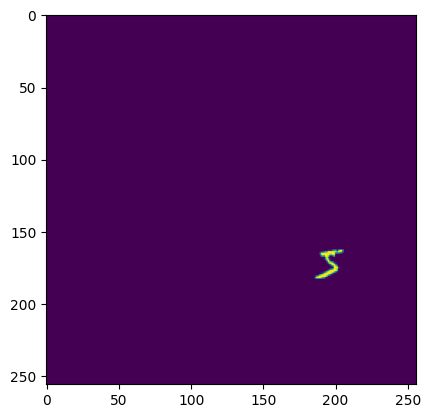

In [9]:
plt.imshow(train_images[0])

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

def crop_and_resize_batch(images, boxes, target_size=(28, 28)):
    """
    Applies cropping and resizing to each image in a batch with corresponding bounding boxes.
    
    :param images: A 4-D Tensor of shape [batch_size, height, width, channels].
    :param boxes: A 2-D Tensor of shape [batch_size, 4] containing bounding boxes.
    :param target_size: A tuple specifying the target height and width.
    :return: A 4-D Tensor of cropped and resized images.
    """
    batch_size = tf.shape(images)[0]

    # Create a tensor for box indices
    box_indices = tf.range(batch_size)

    # Convert target size to a tensor
    crop_size = tf.constant(target_size, dtype=tf.int32)

    # Use tf.image.crop_and_resize
    cropped_resized_images = tf.image.crop_and_resize(
        images,
        boxes,
        box_indices,
        crop_size,
        method='bilinear'
    )

    return cropped_resized_images

class CroppingAndResizingLayer(tf.keras.layers.Layer):
    def __init__(self, target_size=(28, 28), **kwargs):
        super(CroppingAndResizingLayer, self).__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs):
        images, boxes = inputs
        image_shape = tf.shape(images)[1:3]
        y1 = boxes[:, 1]
        x1 = boxes[:, 0]
        y2 = boxes[:, 3]
        x2 = boxes[:, 2]
        correct_boxes = tf.stack([y1, x1, y2, x2], axis=1)
        return crop_and_resize_batch(images, correct_boxes, self.target_size)

def create_model():
    input_layer = Input(shape=(256, 256, 1))
    
    # Base convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    # Localization branch predicts coordinates for cropping
    localization = Dense(128, activation='relu')(x)
    coords = Dense(4, activation='sigmoid', name='localization_output')(localization)  # Named output for localization
    
    # Cropping layer
    crop_layer = CroppingAndResizingLayer(target_size=(28, 28))([input_layer, coords])
    
    # Classification branch
    classification_input = Flatten()(crop_layer)
    classification = Dense(128, activation='relu')(classification_input)
    classification = Dropout(0.5)(classification)
    classification_output = Dense(10, activation='softmax', name='classification_output')(classification)  # Named output for classification
    
    # Construct the full model
    model = Model(inputs=input_layer, outputs=[coords, classification_output])
    
    return model

model = create_model()

In [19]:
from tensorflow.keras import backend as K
import tensorflow as tf

def clear_session():
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    # Clear the GPU memory
    from tensorflow.python.framework import ops
    ops.reset_default_graph()

clear_session()

In [20]:
os.environ['TF_XLA_FLAGS'] = '--xla_gpu_enable_xla_devices=false'


In [8]:
model.compile(
    optimizer='adam',
    loss={
        'localization_output': 'mean_squared_error',  # Corrected to the actual output layer name
        'classification_output': 'sparse_categorical_crossentropy'  # Corrected to the actual output layer name
    },
    loss_weights={
        'localization_output': 1.0,  # Ensure the weight matches the importance of the task
        'classification_output': 1.0  # Ensure the weight matches the importance of the task
    },
    metrics={
        'localization_output': ['mae'],  # Metrics for the localization output
        'classification_output': ['accuracy']  # Metrics for the classification output
    }
)

In [9]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_images, 
        {
            'localization_output': train_bboxes, 
            'classification_output': train_labels
        },
        validation_data=(
            test_images, 
            {
                'localization_output': test_bboxes, 
                'classification_output': test_labels
            }
        ),
        epochs=10,
        batch_size=32
    )


Epoch 1/10


W0000 00:00:1722966723.825529 2755170 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -8 } dim { size: 256 } dim { size: 256 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2999 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 134217728 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { siz

 75/157 ━━━━━━━━━━━━━━━━━━━━ 56s 685ms/step - classification_output_accuracy: 0.1026 - localization_output_mae: 0.3864 - loss: 2.5206

In [97]:
print(test_images.shape)
y_pred = model.predict(test_images)


(250, 256, 256, 1)


2024-08-02 19:48:07.516445: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 64.00MiB (67108864 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/mattwilk/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/mattwilk/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2262476/2676898038.py", line 2, in <module>

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

Failed to allocate 67108864 bytes for new constant
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_452199]

[0.015625  0.2421875 0.125     0.3515625]
[0.02744406 0.26661    0.12616605 0.38507006]
7
[0.08879827 0.10580781 0.07657495 0.1211955  0.14983183 0.11164243
 0.07547764 0.12235857 0.09281766 0.05549541]


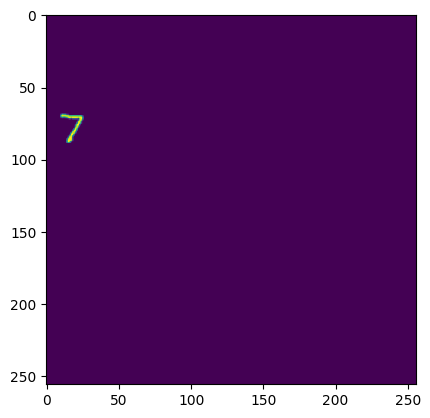

In [54]:
plt.imshow(test_images[0])
print(test_bboxes[0])
print(y_pred[0][0])
print(test_labels[0])
print(y_pred[1][0])

tf.Tensor([28 28], shape=(2,), dtype=int32)
tf.Tensor(
[[0.1171875  0.5234375  0.2265625  0.6328125 ]
 [0.17578125 0.3671875  0.28515625 0.4765625 ]
 [0.765625   0.12109375 0.875      0.23046875]
 [0.58984375 0.5390625  0.69921875 0.6484375 ]
 [0.06640625 0.54296875 0.17578125 0.65234375]], shape=(5, 4), dtype=float32)


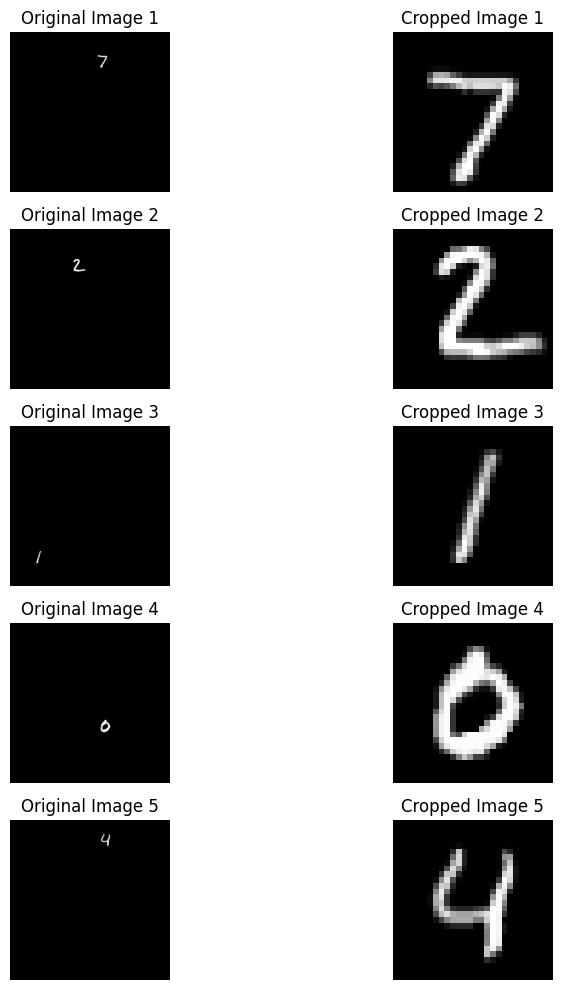

In [33]:
def test_crop_layer():
    # Create dummy data
    batch_size = 1
    img_height, img_width = 256, 256
    channels = 1
    target_size = (28, 28)
    
    dummy_images = test_images
    dummy_coords = test_bboxes
    
    crop_layer = CroppingAndResizingLayer(target_size=target_size)
    
    cropped_images = crop_layer([dummy_images, dummy_coords])
    
    # Plot the original and cropped images for the first 5 examples
    plt.figure(figsize=(10, 10))
    for i in range(5):
        original_image = test_images[i]
        cropped_image = cropped_images[i, :, :, 0].numpy()
        
        plt.subplot(5, 2, 2 * i + 1)
        plt.title(f"Original Image {i+1}")
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')
        
        plt.subplot(5, 2, 2 * i + 2)
        plt.title(f"Cropped Image {i+1}")
        plt.imshow(cropped_image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the test function
test_crop_layer()

#4-32 62-90